In [27]:
import time
start = time.time()

In [28]:
import re
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import umap
import nltk
import spacy
import string
import hdbscan

import preprocessor as p

import matplotlib.pyplot as plt
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import seaborn as sns
sns.set(style='white', rc={'figure.figsize':(10,8)})

np.random.seed(42)
%config Completer.use_jedi = False
pd.set_option('display.max_columns', 30)
# pd.set_option('display.max_rows', 100)

nlp = spacy.load("en_core_web_sm")

In [29]:
df = pd.read_csv('mindvalley_fb_comments.csv')
df.rename(columns={"comment":"comments"},inplace=True)
df.head()

,Unnamed: 0,comments
0,0,After this class you'll see why Silicon Valley...
1,1,The shirt is almost identical to my moms fancy...
2,2,"When you buy a program, can you stop, backup,..."
3,3,Exactly what is lucid dreaming? Thank you for ...
4,4,"I have lucid dreams all the time, also have ov..."


In [30]:
df.comments.replace("\n" , " ", regex=True, inplace = True)
df.comments=df.comments.apply(lambda x:p.clean(str(x)))

In [31]:
df.replace('nan', np.nan, inplace = True)
df.replace('', np.nan, inplace = True)
df.replace('do', np.nan, inplace = True)
df = df.dropna()

In [32]:
list_data = df.comments.unique().tolist()

In [33]:
from sentence_transformers import SentenceTransformer

In [34]:
# distilbert-base-nli-mean-tokens
# paraphrase-distilroberta-base-v1
# roberta-large-nli-stsb-mean-tokens
#allenai-specter


In [35]:
%%time
model=SentenceTransformer('xlm-r-distilroberta-base-paraphrase-v1')
embeddings = model.encode(list_data, show_progress_bar=True)

Batches:   0%|          | 0/33 [00:00<?, ?it/s]

Wall time: 1min 18s


In [36]:
%%time
best_model = umap.UMAP(n_components=5,min_dist=0.0).fit_transform(embeddings)

#n_neighbors=10, min_dist=0.0, 

Wall time: 5.52 s


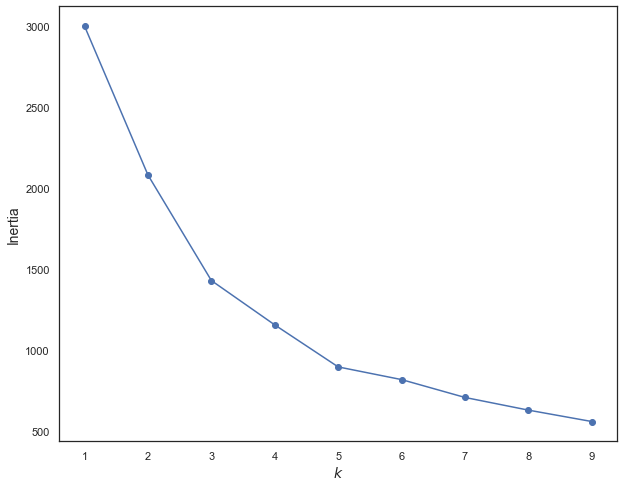

In [37]:
#inertia

kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(best_model)
                for k in range(1, 10)]
inertias = [model.inertia_ for model in kmeans_per_k]

plt.plot(range(1, 10), inertias, "bo-")
plt.xlabel("$k$", fontsize=14)
plt.ylabel("Inertia", fontsize=14)
plt.show()

In [38]:
# from nltk.cluster import KMeansClusterer,euclidean_distance
# clusterer =KMeansClusterer(6,euclidean_distance)
# cluster=np.array(clusterer.cluster(best_model,True))

In [39]:
# cluster = KMeans(n_clusters=1, init="k-means++").fit_predict(best_model)

In [40]:
cluster = hdbscan.HDBSCAN().fit_predict(best_model)

In [41]:
def plot(cluster = cluster):    

    clustered = (cluster >= 0)
    reduced_dim = umap.UMAP(n_components=2).fit_transform(embeddings)



    unique, counts = np.unique(cluster, return_counts=True)
    print(dict(zip(unique, counts)))

    plt.scatter(reduced_dim[~clustered, 0],
                reduced_dim[~clustered, 1],
                c=(0.5,0.5,0.5),
                # s=1,
                alpha=0.5
                )
    plt.scatter(reduced_dim[clustered, 0],
                reduced_dim[clustered, 1],
                c=cluster[clustered],
                # s=1,
                cmap='hsv')
    plt.show()

{-1: 386, 0: 13, 1: 6, 2: 20, 3: 6, 4: 31, 5: 22, 6: 6, 7: 29, 8: 15, 9: 6, 10: 6, 11: 8, 12: 52, 13: 7, 14: 11, 15: 9, 16: 6, 17: 6, 18: 23, 19: 7, 20: 6, 21: 15, 22: 15, 23: 6, 24: 144, 25: 8, 26: 25, 27: 8, 28: 27, 29: 15, 30: 10, 31: 9, 32: 23, 33: 11, 34: 22, 35: 7, 36: 8, 37: 19}


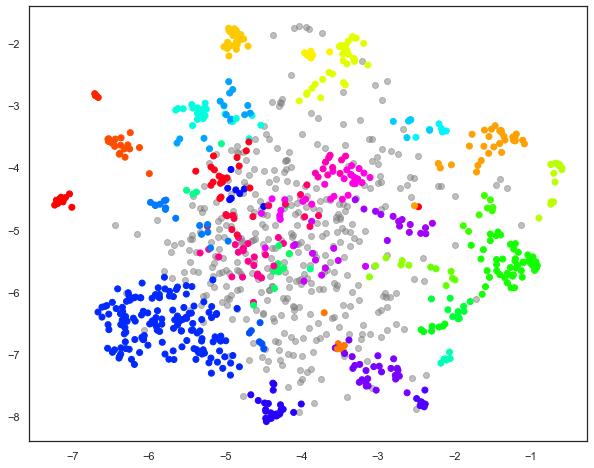

In [42]:
plot()

In [43]:
len(cluster)

1053

In [44]:
def word_root(text):
    list_data3=[]
    doc = nlp(text)
    for token in doc:
        if token.text.isalpha() and len(token.text)>2:
            lemma = token.lemma_
            list_data3.append(lemma)
        else:pass
    return " ".join(list_data3)

In [45]:
docs = pd.DataFrame(list_data,columns=["comments"])
docs["cluster"] = cluster
labeled_docs = docs.groupby(["cluster"], as_index=False).agg({"comments": " ".join})
labeled_docs.comments = labeled_docs.comments.apply(lambda x: word_root(str(x).lower()))  
labeled_docs

,cluster,comments
0,-1,after this class you see why silicon valley co...
1,0,genuine faithful love loving care encourage gr...
2,1,sorry for post message here really need your h...
3,2,its opportunity learn and grow and understand ...
4,3,welcome happy morning hello hello hello all th...
5,4,more gratitude and more power you you be amazi...
6,5,prayer protect you and cure our lord have wron...
7,6,this week masterclass eric will share powerful...
8,7,join charlie and vishen lakhiani brand new mas...
9,8,arigato for the all money have expend and hope...


In [46]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 8 	 cluster 19 	 similarity: 0.6837
cluster 14 	 cluster 15 	 similarity: 0.6737
cluster 1 	 cluster 14 	 similarity: 0.6109
cluster 5 	 cluster 8 	 similarity: 0.5636
cluster 5 	 cluster 12 	 similarity: 0.5633
cluster 9 	 cluster 13 	 similarity: 0.5553
cluster 5 	 cluster 21 	 similarity: 0.5532
cluster 20 	 cluster 21 	 similarity: 0.5435
cluster 6 	 cluster 13 	 similarity: 0.5335
cluster 18 	 cluster 29 	 similarity: 0.5315
cluster 5 	 cluster 20 	 similarity: 0.5313
cluster 13 	 cluster 38 	 similarity: 0.5265
cluster 6 	 cluster 38 	 similarity: 0.5218
cluster 5 	 cluster 10 	 similarity: 0.5197
cluster 12 	 cluster 13 	 similarity: 0.5045
cluster 10 	 cluster 31 	 similarity: 0.5016
cluster 11 	 cluster 29 	 similarity: 0.4997
cluster 1 	 cluster 15 	 similarity: 0.4995
cluster 22 	 cluster 38 	 similarity: 0.4987
cluster 12 	 cluster 30 	 similarity: 0.4981
cluster 5 	 cluster 19 	 similarity: 0.4977
cluster 5 	 cluster 36 	 similarity: 0.4881
clust

In [47]:
%%time
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1



Wall time: 63 ms


<timed exec>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [48]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)
labeled_docs

,cluster,comments
0,-1,after this class you see why silicon valley co...
1,0,genuine faithful love loving care encourage gr...
2,1,sorry for post message here really need your h...
3,2,its opportunity learn and grow and understand ...
4,3,welcome happy morning hello hello hello all th...
5,4,prayer protect you and cure our lord have wron...
6,6,this week masterclass eric will share powerful...
7,9,muy buenos das estoy muy glad see you mind val...
8,10,what beautiful woman such beautiful woman and ...
9,15,after one month and not quite fail each time k...


In [49]:
%%time
array_text = labeled_docs.comments.tolist()
from sentence_transformers import SentenceTransformer, util

sentences = array_text[1:]

#Encode all sentences
embeddings = model.encode(sentences)

#Compute cosine similarity between all pairs
cos_sim = util.pytorch_cos_sim(embeddings, embeddings)

#Add all pairs to a list with their cosine similarity score
all_sentence_combinations = []
for i in range(len(cos_sim)-1):
    for j in range(i+1, len(cos_sim)):
        all_sentence_combinations.append([cos_sim[i][j], i, j])

#Sort list by the highest cosine similarity score
all_sentence_combinations = sorted(all_sentence_combinations, key=lambda x: x[0], reverse=True)
similar = []
print("Top similar pairs:")
for score, i, j in all_sentence_combinations:
    print("cluster {} \t cluster {} \t similarity: {:.4f}".format(i+1, j+1, cos_sim[i][j]))
    similar.append((score,i+1,j+1))

Top similar pairs:
cluster 1 	 cluster 8 	 similarity: 0.4558
cluster 7 	 cluster 8 	 similarity: 0.4481
cluster 1 	 cluster 13 	 similarity: 0.4270
cluster 1 	 cluster 7 	 similarity: 0.4238
cluster 8 	 cluster 17 	 similarity: 0.4226
cluster 1 	 cluster 14 	 similarity: 0.4002
cluster 9 	 cluster 11 	 similarity: 0.3965
cluster 6 	 cluster 11 	 similarity: 0.3821
cluster 1 	 cluster 3 	 similarity: 0.3765
cluster 3 	 cluster 17 	 similarity: 0.3695
cluster 7 	 cluster 16 	 similarity: 0.3596
cluster 7 	 cluster 13 	 similarity: 0.3542
cluster 1 	 cluster 5 	 similarity: 0.3526
cluster 6 	 cluster 9 	 similarity: 0.3522
cluster 3 	 cluster 6 	 similarity: 0.3486
cluster 3 	 cluster 8 	 similarity: 0.3448
cluster 11 	 cluster 17 	 similarity: 0.3372
cluster 13 	 cluster 17 	 similarity: 0.3326
cluster 1 	 cluster 9 	 similarity: 0.3269
cluster 2 	 cluster 5 	 similarity: 0.3250
cluster 1 	 cluster 2 	 similarity: 0.3239
cluster 2 	 cluster 3 	 similarity: 0.3230
cluster 5 	 cluster 7 	

In [50]:
similar

[(tensor(0.4558), 1, 8),
 (tensor(0.4481), 7, 8),
 (tensor(0.4270), 1, 13),
 (tensor(0.4238), 1, 7),
 (tensor(0.4226), 8, 17),
 (tensor(0.4002), 1, 14),
 (tensor(0.3965), 9, 11),
 (tensor(0.3821), 6, 11),
 (tensor(0.3765), 1, 3),
 (tensor(0.3695), 3, 17),
 (tensor(0.3596), 7, 16),
 (tensor(0.3542), 7, 13),
 (tensor(0.3526), 1, 5),
 (tensor(0.3522), 6, 9),
 (tensor(0.3486), 3, 6),
 (tensor(0.3448), 3, 8),
 (tensor(0.3372), 11, 17),
 (tensor(0.3326), 13, 17),
 (tensor(0.3269), 1, 9),
 (tensor(0.3250), 2, 5),
 (tensor(0.3239), 1, 2),
 (tensor(0.3230), 2, 3),
 (tensor(0.3168), 5, 7),
 (tensor(0.3160), 1, 17),
 (tensor(0.3128), 4, 8),
 (tensor(0.3127), 7, 17),
 (tensor(0.3101), 6, 7),
 (tensor(0.3098), 9, 16),
 (tensor(0.3066), 1, 16),
 (tensor(0.3064), 5, 16),
 (tensor(0.3015), 1, 11),
 (tensor(0.3012), 1, 12),
 (tensor(0.2983), 1, 4),
 (tensor(0.2959), 2, 16),
 (tensor(0.2956), 1, 6),
 (tensor(0.2919), 8, 13),
 (tensor(0.2866), 3, 7),
 (tensor(0.2860), 9, 17),
 (tensor(0.2802), 9, 12),
 (

In [51]:
i=0
while similar[i][0]>0.40:
    one, two = sorted([similar[i][1],similar[i][2]])
    if labeled_docs.comments[one] == "" and labeled_docs.comments[two] == "":
        pass
    elif labeled_docs.comments[one] == "" and labeled_docs.comments[two] != "":
        labeled_docs.comments[one] = labeled_docs.comments[two]
    else:
        labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
    labeled_docs.comments[two]=""
    i+=1

<ipython-input-51-b03d7faa43c8>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_docs.comments[one] = labeled_docs.comments[one] +" "+labeled_docs.comments[two]
c:\users\user\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3418: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-51-b03d7faa43c8>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

In [52]:
labeled_docs.replace('', np.nan, inplace = True)
labeled_docs=labeled_docs.dropna()
labeled_docs.reset_index(drop=True,inplace=True)
labeled_docs

c:\users\user\appdata\local\programs\python\python38\lib\site-packages\pandas\core\frame.py:4521: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(


,cluster,comments
0,-1,after this class you see why silicon valley co...
1,0,genuine faithful love loving care encourage gr...
2,1,sorry for post message here really need your h...
3,2,its opportunity learn and grow and understand ...
4,3,welcome happy morning hello hello hello all th...
5,4,prayer protect you and cure our lord have wron...
6,6,this week masterclass eric will share powerful...
7,10,exactly she do say anything new insightful oth...
8,15,after one month and not quite fail each time k...
9,16,how sit goal and stick its would ask how you f...


In [53]:
labeled_docs

,cluster,comments
0,-1,after this class you see why silicon valley co...
1,0,genuine faithful love loving care encourage gr...
2,1,sorry for post message here really need your h...
3,2,its opportunity learn and grow and understand ...
4,3,welcome happy morning hello hello hello all th...
5,4,prayer protect you and cure our lord have wron...
6,6,this week masterclass eric will share powerful...
7,10,exactly she do say anything new insightful oth...
8,15,after one month and not quite fail each time k...
9,16,how sit goal and stick its would ask how you f...


In [54]:
%%time
from keybert import KeyBERT
array_text = labeled_docs.comments.tolist()
kw_extractor = KeyBERT(model=model)
bigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(2, 2))
    print(f'\033[1m   Bigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    bigram.append([word[0] for word in keywords])

   Bigram Cluster 1: 
[('compassion love', 0.6953), ('kind love', 0.6554), ('generous love', 0.648), ('passionate love', 0.6261), ('love love', 0.6248), ('love loving', 0.622), ('faithful love', 0.6143), ('love passionate', 0.6061), ('loyal loving', 0.6031), ('passionate loyal', 0.5994)]
   Bigram Cluster 2: 
[('militer mohon', 0.5886), ('military want', 0.5092), ('stop military', 0.4459), ('military kindly', 0.4426), ('urge urgent', 0.4245), ('perhatian mendesak', 0.424), ('need urgent', 0.4211), ('mohon bantu', 0.4156), ('detain military', 0.4139), ('military try', 0.4135)]
   Bigram Cluster 3: 
[('learn history', 0.542), ('american history', 0.5032), ('teach history', 0.5004), ('educate black', 0.4963), ('history american', 0.4822), ('america history', 0.4773), ('black history', 0.4698), ('history teach', 0.4609), ('time learn', 0.4492), ('opportunity learn', 0.4467)]
   Bigram Cluster 4: 
[('hello people', 0.6164), ('happy morning', 0.6111), ('morning hello', 0.6043), ('people mexi

In [55]:
%%time
unigram=[]
for j in range(len(array_text)-1):
    keywords = kw_extractor.extract_keywords(array_text[j+1],top_n=10,keyphrase_ngram_range=(1, 1))
    print(f'\033[1m   Unigram Cluster {j+1}: \033[0m' )
    print([word for word in keywords])
    unigram.append([word[0] for word in keywords])

   Unigram Cluster 1: 
[('love', 0.5326), ('loving', 0.5197), ('compassion', 0.5171), ('passionate', 0.5063), ('loyal', 0.4622), ('appreciate', 0.4499), ('respect', 0.4435), ('dedication', 0.4232), ('lovely', 0.4101), ('heart', 0.4081)]
   Unigram Cluster 2: 
[('mohon', 0.3645), ('bantu', 0.3622), ('military', 0.3551), ('militer', 0.3522), ('urgent', 0.35), ('membutuhkan', 0.3475), ('militar', 0.3202), ('mendesak', 0.315), ('menghentikan', 0.3133), ('want', 0.3117)]
   Unigram Cluster 3: 
[('aprendizaje', 0.3251), ('learn', 0.3224), ('commemorate', 0.3189), ('history', 0.2878), ('racism', 0.2807), ('america', 0.2689), ('american', 0.2682), ('learning', 0.2612), ('african', 0.2597), ('educate', 0.2454)]
   Unigram Cluster 4: 
[('hello', 0.484), ('welcome', 0.4497), ('mexico', 0.3989), ('morning', 0.3668), ('happy', 0.3443), ('people', 0.2425)]
   Unigram Cluster 5: 
[('bless', 0.4378), ('prayer', 0.4071), ('neodstihnete', 0.3916), ('blessing', 0.3872), ('merciful', 0.367), ('repent', 0.

In [56]:
for i in range(len(array_text)-1):
    clusterer=[]
    bigramer=[]
    print(f'\033[1m   Cluster {i+1}: \033[0m')
    [clusterer.append(j) for j in unigram[i]]
    clusterer.append(bigram[i][0])
    
    for word in bigram[i][0].split(" "):
        if word not in bigramer:
            bigramer.append(word)
    
    for each in bigram[i]:
        first,second=each.split(" ")
        if first != second and not(first in bigramer and second in bigramer):
            clusterer.append(each)
            if bigramer.append(first): first not in bigramer
            if bigramer.append(second): second not in bigramer
    print(clusterer)

   Cluster 1: 
['love', 'loving', 'compassion', 'passionate', 'loyal', 'appreciate', 'respect', 'dedication', 'lovely', 'heart', 'compassion love', 'kind love', 'generous love', 'passionate love', 'love loving', 'faithful love', 'loyal loving']
   Cluster 2: 
['mohon', 'bantu', 'military', 'militer', 'urgent', 'membutuhkan', 'militar', 'mendesak', 'menghentikan', 'want', 'militer mohon', 'military want', 'stop military', 'military kindly', 'urge urgent', 'perhatian mendesak', 'need urgent', 'mohon bantu', 'detain military', 'military try']
   Cluster 3: 
['aprendizaje', 'learn', 'commemorate', 'history', 'racism', 'america', 'american', 'learning', 'african', 'educate', 'learn history', 'american history', 'teach history', 'educate black', 'america history', 'time learn', 'opportunity learn']
   Cluster 4: 
['hello', 'welcome', 'mexico', 'morning', 'happy', 'people', 'hello people', 'happy morning', 'people mexico', 'welcome happy']
   Cluster 5: 
['bless', 'prayer', 'neodstihnete', 'b

In [57]:
end = time.time()
print(end - start)

220.01187181472778
